<a href="https://colab.research.google.com/github/Blackbirdf16/Cryptography-/blob/main/qiskit/Superposicion.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Instalar SDK**

In [ ]:
!pip install "qiskit[visualization]" qiskit-aer qiskit-ibm-runtime

**Dependencias de la SDK**

In [ ]:
from qiskit import QuantumCircuit
from qiskit_ibm_runtime.fake_provider import FakeAlmadenV2
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit_aer.primitives import SamplerV2
from qiskit.visualization import plot_histogram

**Funciones auxiliares para visualización**

In [ ]:
from matplotlib import pyplot as plt
from IPython.display import HTML, display, Image
import matplotlib.animation as animation

def muestra_counts(qubit_counts):
  columnas = ['00', '01', '10', '11']
  values = [qubit_counts.get(col, 0) for col in columnas]

  plt.bar(columnas, values)
  plt.xlabel("qubits")
  plt.ylabel("counts")
  plt.show()

def plot_circuit_samples(circuito,sampler):
  # Configurar la figura
  fig, ax = plt.subplots()
  columnas = ['00', '01', '10', '11']
  bar_container = ax.bar(columnas, [0, 0, 0, 0])
  ax.set_xlabel("Qubits")
  ax.set_ylabel("Counts")
  ax.set_ylim(0, 600)  # Ajusta esto según los valores esperados

  # Función para actualizar el gráfico en cada frame
  def update(frame):
      job = sampler.run([circuito])
      result = job.result()
      qubit_counts = result[0].data.meas.get_counts()
      values = [qubit_counts.get(col, 0) for col in columnas]

      for bar, new_height in zip(bar_container, values):
          bar.set_height(new_height)

      return bar_container

  # Crear la animación
  ani = animation.FuncAnimation(fig, update, frames=50, interval=200, blit=False)

  # Cerrar el gráfico estático para evitar que aparezca en Jupyter
  plt.close(fig)

  # Guardar la animación como un GIF temporalmente
  ani.save("/tmp/animacion.gif", writer="pillow", fps=10)

  # Mostrar el GIF en Google Colab
  display(Image(filename="/tmp/animacion.gif"))

**Qiskit Fundamentals**

This notebook demonstrates some fundamental concepts in quantum computing using Qiskit, including superposition and the difference between exact and noisy simulations.

Let's start by creating a simple quantum circuit with two qubits.

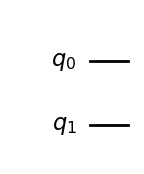

In [ ]:
circuito = QuantumCircuit(2)

circuito.draw("mpl")

Applying a Hadamard gate to a qubit creates a superposition, meaning the qubit is in a combination of both the |0> and |1> states simultaneously.

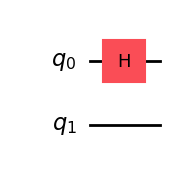

In [ ]:
circuito.h(0)
circuito.draw("mpl")

To observe the state of the qubits, we need to measure them. Measurement collapses the superposition to a definite state (|0> or |1>).

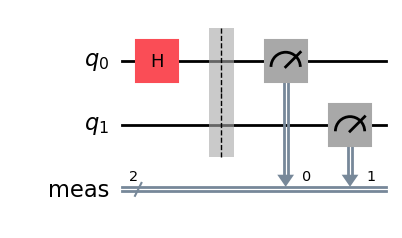

In [ ]:
circuito.measure_all()
circuito.draw("mpl")

We can use a `SamplerV2` to simulate the quantum circuit and get the probability distribution of the measurement outcomes. This sampler provides exact simulation results by default.

In [ ]:
sampler = SamplerV2()

In order to get the samples, we pass the circuit to the sampler with the following command: `sampler.run(circuits)`. Ideally we will pass the sampler a list of circuits to run, but in our case the list only contains one circuit. Finally we need to call `.result()` to wait for the simulator to finish the execution and return all the samples. Let's run the circuit with the sampler and see the results.

In [ ]:
resultado = sampler.run([circuito]).result()
resultado

PrimitiveResult([SamplerPubResult(data=DataBin(meas=BitArray(<shape=(), num_shots=1024, num_bits=2>)), metadata={'shots': 1024, 'circuit_metadata': {}, 'simulator_metadata': {'time_taken_parameter_binding': 1.6891e-05, 'time_taken_execute': 0.002648937, 'omp_enabled': True, 'max_gpu_memory_mb': 0, 'max_memory_mb': 12975, 'parallel_experiments': 1}})], metadata={'version': 2})

The result object contains the measurement outcomes. We can extract the counts of each outcome. We can visualize the results as a histogram to see the distribution of measurement outcomes. The `plot_circuit_samples` function runs the circuit multiple times and shows how the measurement counts build up over time.

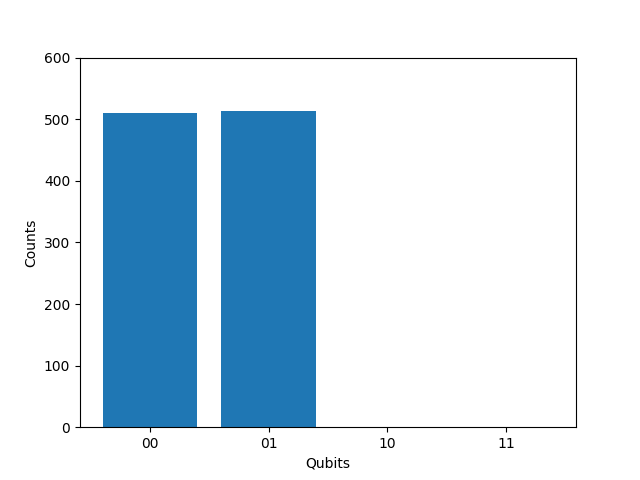

In [ ]:
plot_circuit_samples(circuito,sampler)

Now, let's create a Bell state, which is an entangled state of two qubits. This state shows strong correlations between the measurement outcomes of the two qubits.

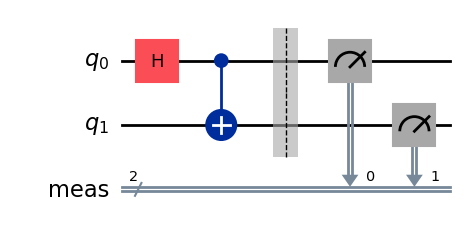

In [ ]:
circuito_bell = QuantumCircuit(2)
circuito_bell.h(0)
circuito_bell.cx(0,1)
circuito_bell.measure_all()
circuito_bell.draw("mpl")

Now, let's run the Bell circuit using the exact sampler.

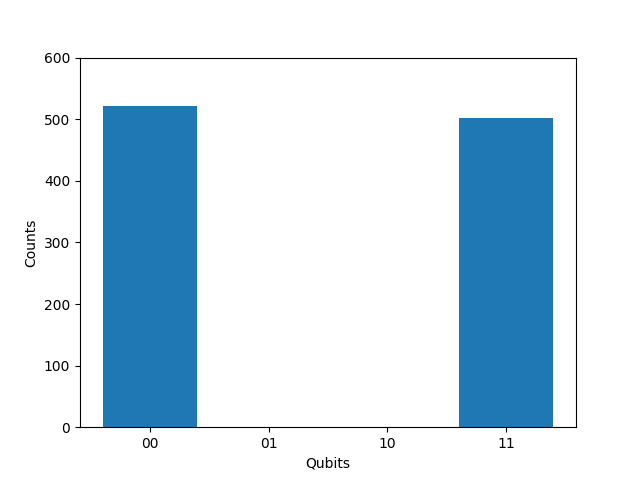

In [ ]:
job = sampler.run([circuito_bell])
qubit_counts = job.result()[0].data.meas.get_counts()
plot_circuit_samples(circuito_bell,sampler)

In reality, quantum computers are subject to noise, which can affect the measurement outcomes. We can simulate this by adding a noise model to the sampler. Here, we add a depolarizing error to the CNOT or CX gate.

Now, let's run the Bell circuit with the noisy sampler and compare the results to the exact simulation. You should observe that the noise introduces errors, leading to non-zero probabilities for outcomes other than '00' and '11'.

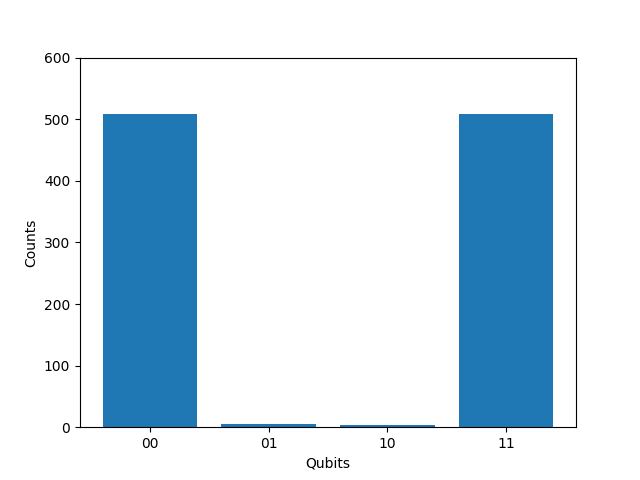

In [ ]:
from qiskit_aer.noise import NoiseModel, depolarizing_error

noise_model = NoiseModel()
cx_depolarizing_prob = 0.02
noise_model.add_all_qubit_quantum_error(
    depolarizing_error(cx_depolarizing_prob, 2), ["cx"]
)
noisy_sampler = SamplerV2(
    options=dict(backend_options=dict(noise_model=noise_model))
)
job = sampler.run([circuito_bell])
qubit_counts = job.result()[0].data.meas.get_counts()
plot_circuit_samples(circuito_bell,noisy_sampler)